<a href="https://colab.research.google.com/github/Harshtherocking/colab-lab/blob/main/hooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VIT

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

from PIL import Image
import torch.nn.functional as F

from torchvision import transforms, models
import urllib.request
import numpy as np

## prep

In [6]:
def preprocess_image(img_path):
    """Load and preprocess images for PyTorch models."""
    img = Image.open(img_path).convert("RGB")
    #Transforms used by imagenet models
    transform = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.Resize((384,384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(img).unsqueeze(0)

In [7]:
def process_grad (grad) :
  g = np.copy(grad)

  if len(g.shape) >= 3 :
    g = np.transpose(g, (1,2,0))

  g = np.maximum(0, g)

  g -= np.min(g)
  g /= (np.max(g) + 1e-9)
  return g


## model loading

In [48]:
from torchvision.models import ViT_B_16_Weights
vit= models.vit_b_16(ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [49]:
vit.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Standard Backprop

In [16]:
img1 = preprocess_image("34.jpg")
img2 = preprocess_image("100.jpg")

In [17]:
img_tensor = img2.clone()
img_tensor.requires_grad = True

In [18]:
pred = vit(img_tensor)
pred.shape

torch.Size([1, 1000])

In [19]:
pred.argmax()

tensor(100)

In [20]:
y = pred.argmax()

pred[:, y].backward()

In [21]:
img_tensor.grad.shape

torch.Size([1, 3, 384, 384])

In [22]:
grad = img_tensor.grad.detach().cpu().numpy()
grad.shape

(1, 3, 384, 384)

In [23]:
pro_grads = process_grad(grad.squeeze())

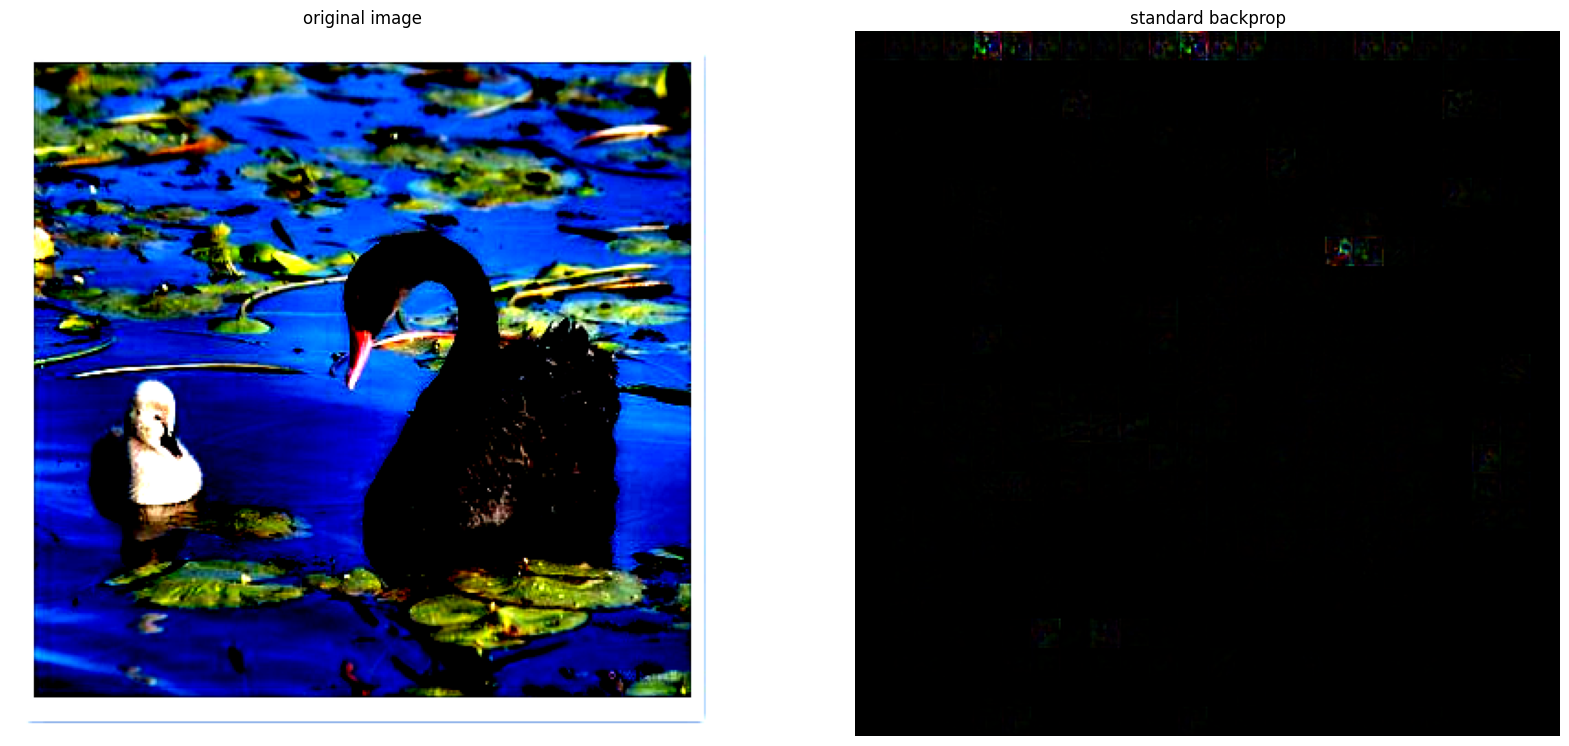

In [24]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(img2.squeeze().permute(1,2,0))
plt.title ("original image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(pro_grads)
plt.title ("standard backprop")
plt.axis("off")
plt.show()

## collecting grad for class token and then interpolating it



In [50]:
gradients = []

def back_hook (model, gradin, gradout) :

  for g in gradout:
    if g is not None :
      gradients.append(g.detach().cpu().numpy())
    else :
      gradients.append(None)

  return

In [51]:
layer = vit.encoder.layers.encoder_layer_10.ln_2
layer

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [52]:
handle = layer.register_full_backward_hook(back_hook)

In [53]:
vit.zero_grad()
img_tensor =  img2.clone()
pred = vit(img_tensor)
y = pred.argmax()
print(f"pred class : {y}")

pred class : 100


In [54]:
pred[:, y].backward()

In [55]:
g = np.stack(gradients)
g.shape

(1, 1, 577, 768)

In [56]:
g

array([[[[-1.70780960e-02, -5.23082912e-03, -2.57046893e-02, ...,
           3.16141769e-02,  2.81245448e-05,  2.16445103e-02],
         [ 2.31751601e-05,  4.41271295e-05,  9.81407265e-06, ...,
          -3.63886284e-06,  1.71469219e-05,  3.71256137e-05],
         [ 3.01886263e-04, -2.54225190e-04,  8.11989885e-05, ...,
          -9.34380296e-06,  5.54939143e-05, -9.68547538e-05],
         ...,
         [ 1.90085091e-04, -1.20286706e-04,  2.41358812e-05, ...,
           2.37026798e-05,  2.65770304e-05, -6.46230983e-05],
         [ 2.01841787e-04, -1.55809917e-04,  2.76094979e-05, ...,
           2.61952882e-05,  5.66427734e-05, -7.70456681e-05],
         [ 2.16871296e-04, -2.09608042e-04,  2.89250420e-05, ...,
           3.97209005e-05,  7.04354316e-05, -1.33171648e-04]]]],
      dtype=float32)

In [57]:
# batch, head,  hxw , channels

In [58]:
def tokens_to_image(arr, num_tokens, num_channels):

    # Remove CLS token (first one)
    patch_tokens = arr[1:, :]  # shape: (num_tokens - 1, num_channels)

    # Compute number of patches per row/col
    num_patches = num_tokens - 1
    grid_size = int(np.sqrt(num_patches))

    assert grid_size * grid_size == num_patches, "num_tokens - 1 must be a perfect square"

    # Reshape to (H, W, C)
    image_array = arr[1:,:].reshape(grid_size, grid_size, num_channels)

    return image_array


In [59]:
grad = tokens_to_image(g[0,0,:,:], g.shape[-2], g.shape[-1] )
grad.shape

(24, 24, 768)

In [60]:
grad.max()

np.float32(0.0050006756)

In [74]:
import random
def plot_random_channels(img_array, n=4, figsize=(12, 8), seed=None):
    H, W, C = img_array.shape
    if seed is not None:
        random.seed(seed)

    # Randomly select n channel indices
    selected_channels = random.sample(range(C), n)

    # Plot
    plt.figure(figsize=figsize)
    for i, ch in enumerate(selected_channels):
        plt.subplot(1, n, i + 1)
        plt.imshow(img_array[:, :, ch], cmap='viridis', interpolation="bilinear")
        plt.title(f'Channel {ch}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

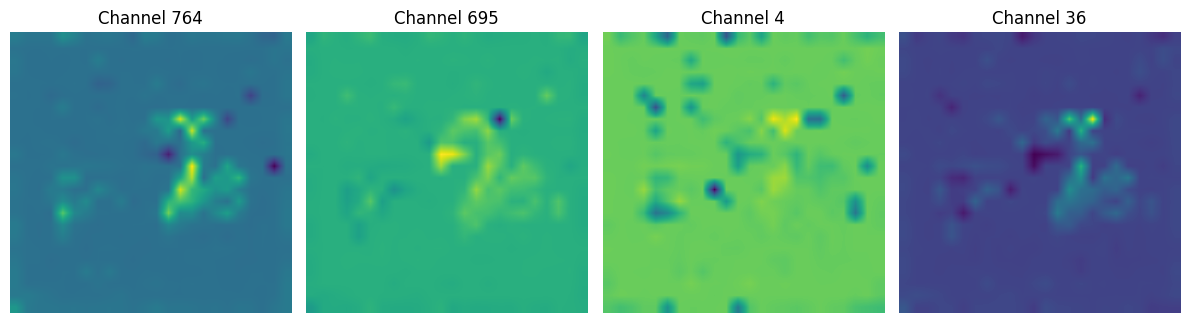

In [75]:
plot_random_channels(grad)